# AEPD WAVE PROJECT
## Análise Exploratória e Pré-Processamento de Dados

**Objetivo:** Análise completa do dataset de feedback para treinamento de modelos de classificação de sentimento.

**Dataset:** `feedback_dataset.csv` - 4.000 amostras de feedback com metadados demográficos e análise de sentimento.

In [3]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'matplotlib'

## 1. Carregamento e Visão Geral dos Dados

In [5]:
# Carregar dataset
github_raw_url = "https://raw.githubusercontent.com/vitorcastellani/feedback-analysis-backend/refs/heads/develop/ml_data/feedback_dataset.csv"
df = pd.read_csv(github_raw_url)

print(f"Dataset Shape: {df.shape}")
print(f"\nColunas disponíveis:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nPrimeiras 3 linhas:")
df.head(3)

Dataset Shape: (4000, 13)

Colunas disponíveis:
   1. feedback_id
   2. campaign_id
   3. gender
   4. age_range
   5. education_level
   6. country
   7. state
   8. message
   9. sentiment_category
  10. sentiment_score
  11. word_count
  12. feedback_length
  13. detected_language

Primeiras 3 linhas:


,feedback_id,campaign_id,gender,age_range,education_level,country,state,message,sentiment_category,sentiment_score,word_count,feedback_length,detected_language
0,1,1,other,65+,master,Italy,Other,A interação com os colegas foi enriquecedora.,neutral,0.0000,7,45,pt
1,2,1,female,35-44,master,Spain,Other,A plataforma é muito intuitiva e fácil de usar.,positive,0.4877,9,47,pt
2,3,1,prefer not to say,other,elementary,Japan,Other,"Bom para iniciantes, mas superficial.",neutral,0.0000,5,37,es


In [4]:
# Informações básicas do dataset
print("Informações do Dataset:")
df.info()

print("\nEstatísticas Descritivas:")
df.describe()

Informações do Dataset:


NameError: name 'df' is not defined

## 2. Análise da Variável Target (Sentiment Category)

Distribuição de Sentimentos:
  positive: 2653 ( 66.3%)
  neutral :  826 ( 20.6%)
  negative:  521 ( 13.0%)

Baseline (classe majoritária): 0.663


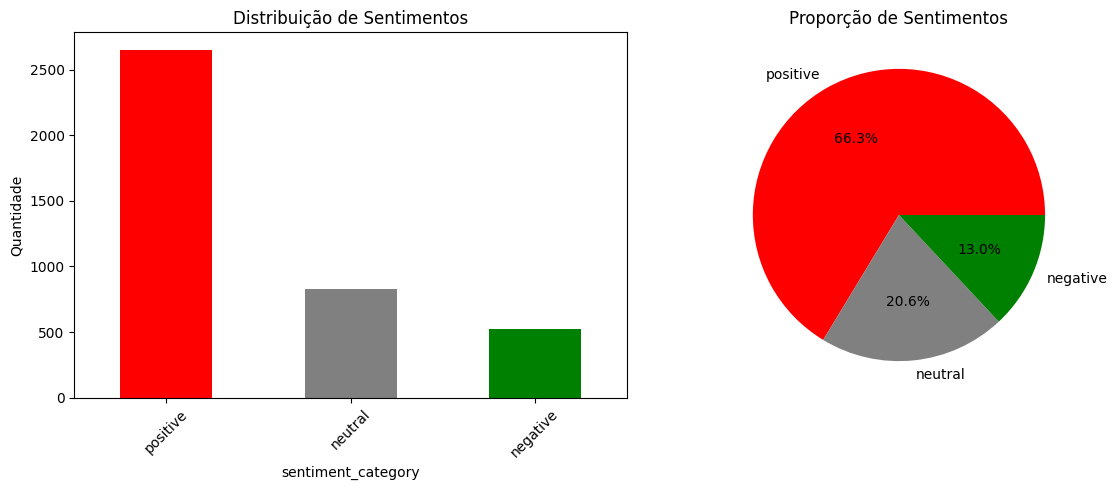

In [10]:
# Distribuição das classes de sentimento
sentiment_counts = df['sentiment_category'].value_counts()
print("Distribuição de Sentimentos:")
for category, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {category:8s}: {count:4d} ({percentage:5.1f}%)")

# Baseline para comparação
majority_baseline = sentiment_counts.max() / len(df)
print(f"\nBaseline (classe majoritária): {majority_baseline:.3f}")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
sentiment_counts.plot(kind='bar', ax=ax1, color=['red', 'gray', 'green'])
ax1.set_title('Distribuição de Sentimentos')
ax1.set_ylabel('Quantidade')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de pizza
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['red', 'gray', 'green'])
ax2.set_title('Proporção de Sentimentos')

plt.tight_layout()
plt.show()

## 3. Detecção de Data Leakage

DETECÇÃO DE DATA LEAKAGE:
   Correlação sentiment_score ↔ sentiment_category: 0.897
ALERTA: Data leakage detectado!
Solução: Excluir sentiment_score das features


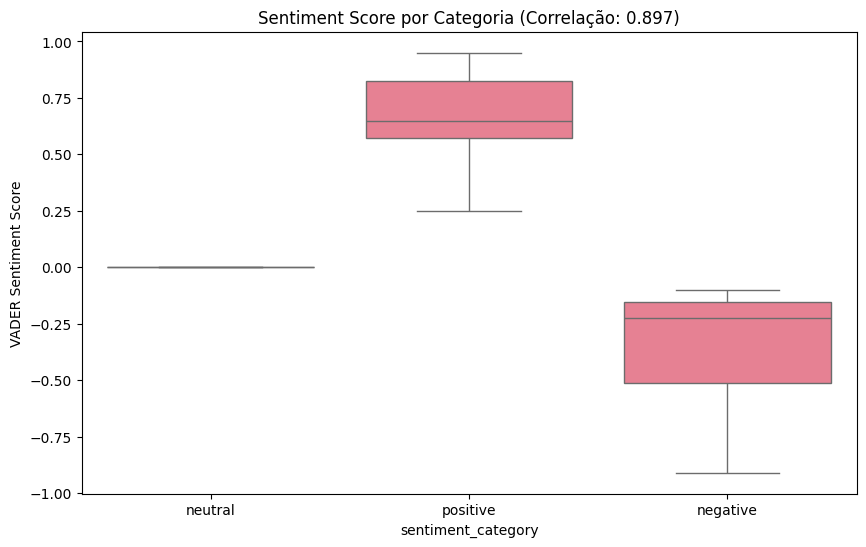

In [11]:
# Verificar correlação entre sentiment_score e sentiment_category
df_temp = df.copy()
le_temp = LabelEncoder()
df_temp['sentiment_encoded'] = le_temp.fit_transform(df_temp['sentiment_category'])

correlation = df_temp['sentiment_score'].corr(df_temp['sentiment_encoded'])

print("DETECÇÃO DE DATA LEAKAGE:")
print(f"   Correlação sentiment_score ↔ sentiment_category: {correlation:.3f}")

if abs(correlation) > 0.7:
    print("ALERTA: Data leakage detectado!")
    print("Solução: Excluir sentiment_score das features")
else:
    print("Sem data leakage significativo")

# Visualizar correlação
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment_category', y='sentiment_score')
plt.title(f'Sentiment Score por Categoria (Correlação: {correlation:.3f})')
plt.ylabel('VADER Sentiment Score')
plt.show()

## 4. Análise de Features de Texto

In [14]:
# Estatísticas de texto por sentimento
print("Análise de Features de Texto:")

text_stats = df.groupby('sentiment_category')[['word_count', 'feedback_length']].agg(['mean', 'std', 'min', 'max'])
print(text_stats.round(2))

# Criar features derivadas
df['avg_word_length'] = df['feedback_length'] / (df['word_count'] + 1)
df['is_very_short'] = (df['word_count'] <= 5).astype(int)
df['is_short'] = (df['word_count'] <= 15).astype(int)
df['is_medium'] = ((df['word_count'] > 15) & (df['word_count'] <= 50)).astype(int)
df['is_long'] = (df['word_count'] > 50).astype(int)
df['text_density'] = df['word_count'] / (df['feedback_length'] + 1)

print("\nFeatures de texto criadas:")
print("   - avg_word_length, text_density")
print("   - is_very_short, is_short, is_medium, is_long")

Análise de Features de Texto:
                   word_count               feedback_length               
                         mean   std min max            mean    std min max
sentiment_category                                                        
negative                 5.97  2.08   2  10           38.17  10.18  20  61
neutral                  4.91  1.45   2   7           33.64   8.67  15  45
positive                 5.53  1.88   2  10           36.33   8.93  15  50

Features de texto criadas:
   - avg_word_length, text_density
   - is_very_short, is_short, is_medium, is_long


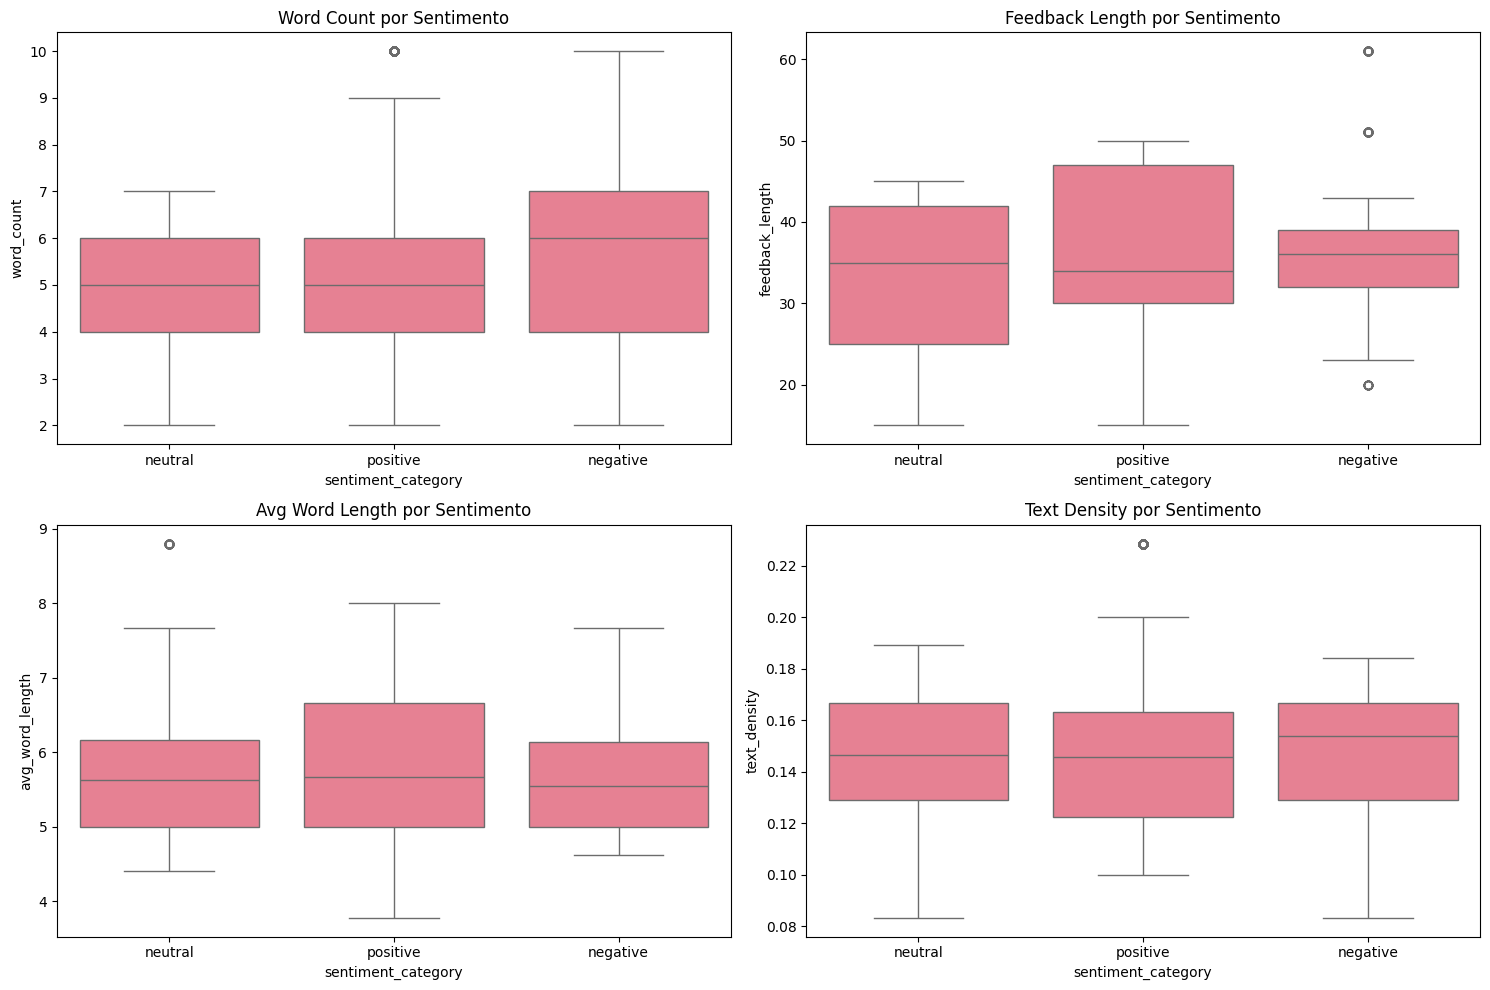

In [15]:
# Visualizações de texto
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count por sentimento
sns.boxplot(data=df, x='sentiment_category', y='word_count', ax=axes[0,0])
axes[0,0].set_title('Word Count por Sentimento')

# Feedback length por sentimento
sns.boxplot(data=df, x='sentiment_category', y='feedback_length', ax=axes[0,1])
axes[0,1].set_title('Feedback Length por Sentimento')

# Average word length por sentimento
sns.boxplot(data=df, x='sentiment_category', y='avg_word_length', ax=axes[1,0])
axes[1,0].set_title('Avg Word Length por Sentimento')

# Text density por sentimento
sns.boxplot(data=df, x='sentiment_category', y='text_density', ax=axes[1,1])
axes[1,1].set_title('Text Density por Sentimento')

plt.tight_layout()
plt.show()

## 5. Análise de Features Demográficas

In [16]:
# Análise demográfica
demographic_cols = ['gender', 'age_range', 'education_level', 'country', 'state', 'detected_language']

print("Distribuição Demográfica:")
for col in demographic_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"  {col:20s}: {unique_count:2d} valores únicos")

        # Top 5 valores mais comuns
        top_values = df[col].value_counts().head(5)
        for value, count in top_values.items():
            print(f"    {value}: {count}")
        print()

Distribuição Demográfica:
  gender              :  4 valores únicos
    male: 1026
    other: 1020
    female: 984
    prefer not to say: 970

  age_range           :  7 valores únicos
    45-54: 622
    18-24: 595
    65+: 588
    55-64: 573
    other: 554

  education_level     :  6 valores únicos
    highschool: 681
    phd: 679
    bachelor: 663
    other: 663
    master: 658

  country             : 25 valores únicos
    South Korea: 181
    Portugal: 177
    Brazil: 174
    China: 171
    France: 171

  state               :  8 valores únicos
    Other: 3826
    SP: 29
    BA: 28
    RS: 26
    RJ: 25

  detected_language   :  4 valores únicos
    pt: 3054
    en: 800
    es: 91
    fr: 55



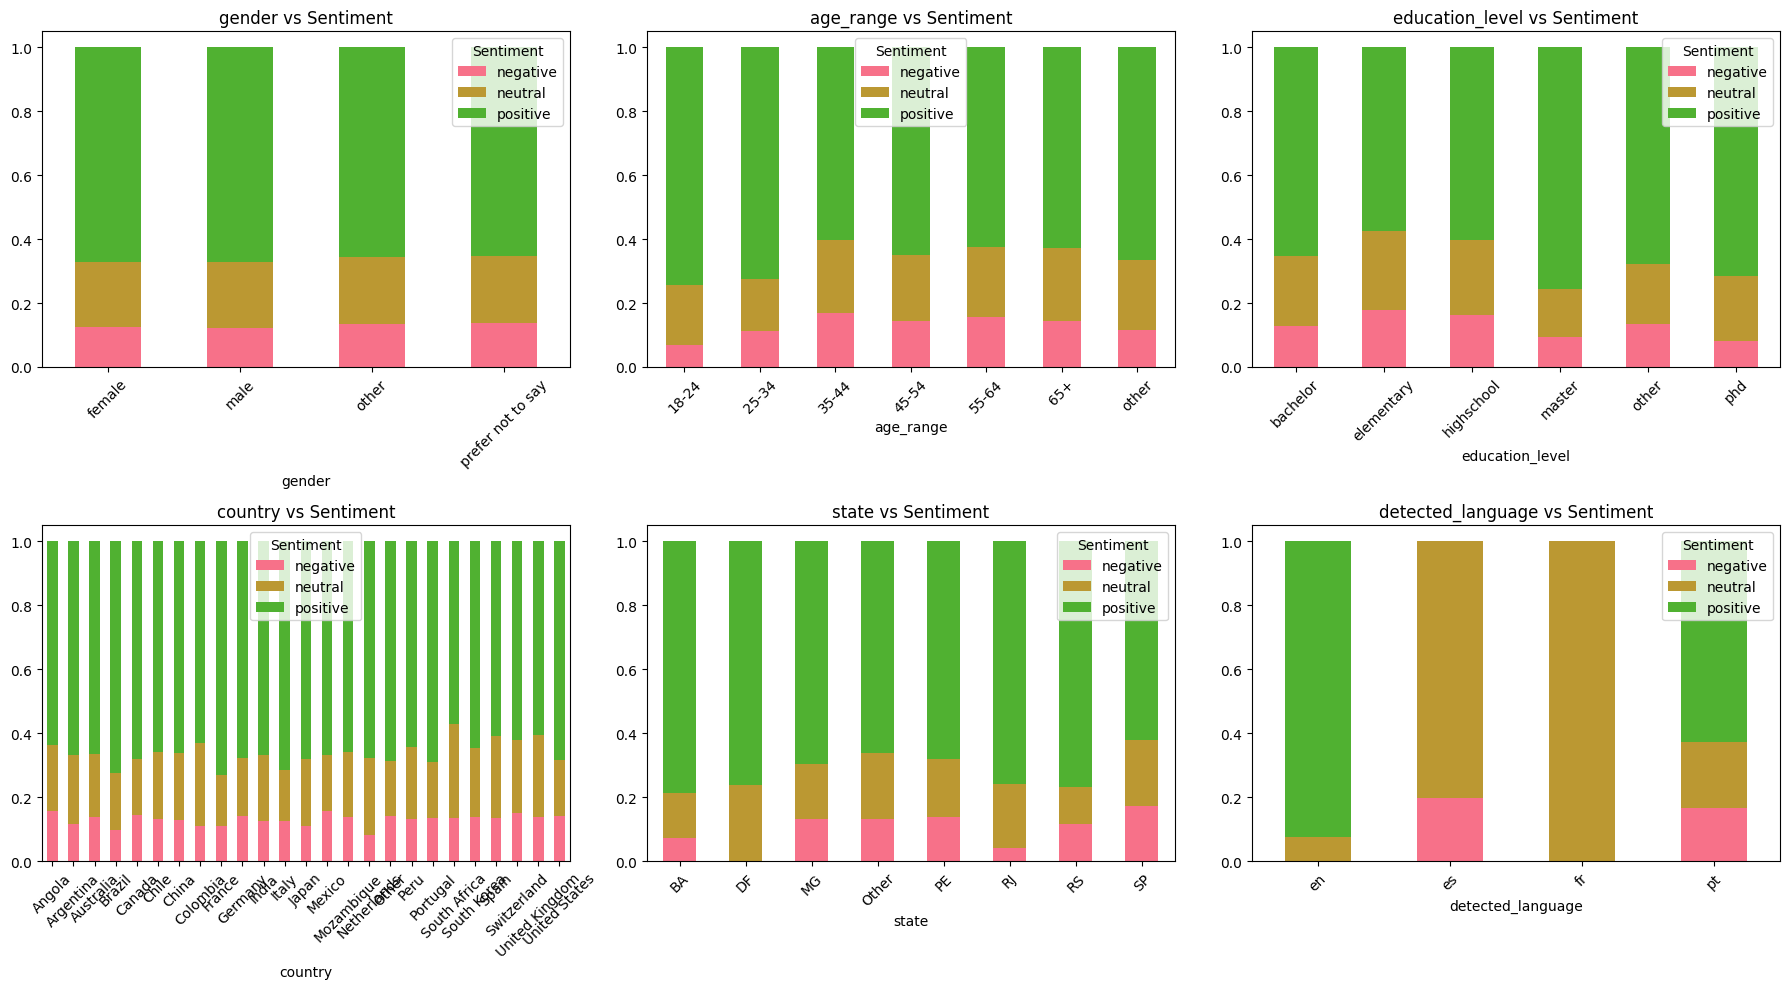

In [17]:
# Visualização demográfica vs sentimento
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(demographic_cols[:6]):
    if col in df.columns:
        # Crosstab para proporções
        ct = pd.crosstab(df[col], df['sentiment_category'], normalize='index')
        ct.plot(kind='bar', ax=axes[i], stacked=True)
        axes[i].set_title(f'{col} vs Sentiment')
        axes[i].legend(title='Sentiment')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Pré-Processamento para Modelagem

In [18]:
# Preparar dados para modelagem (SEM data leakage)
print("Preparando dados para modelagem...")

df_model = df.copy()
encoders = {}

# Encodar variáveis categóricas
categorical_features = ['gender', 'age_range', 'education_level', 'country', 'state', 'detected_language']

for col in categorical_features:
    if col in df_model.columns:
        encoders[col] = LabelEncoder()
        df_model[col] = encoders[col].fit_transform(df_model[col])
        print(f"{col}: encoded")

# Encodar target
encoders['sentiment_category'] = LabelEncoder()
df_model['sentiment_category_encoded'] = encoders['sentiment_category'].fit_transform(df_model['sentiment_category'])
target_names = encoders['sentiment_category'].classes_

print(f"\nTarget classes: {target_names}")

Preparando dados para modelagem...
gender: encoded
age_range: encoded
education_level: encoded
country: encoded
state: encoded
detected_language: encoded

Target classes: ['negative' 'neutral' 'positive']


In [19]:
# Definir features SEGURAS (sem data leakage)
safe_text_features = [
    'word_count', 'feedback_length', 'avg_word_length',
    'is_very_short', 'is_short', 'is_medium', 'is_long', 'text_density'
]

safe_demographic_features = ['gender', 'age_range', 'education_level']

if 'detected_language' in df_model.columns:
    safe_text_features.append('detected_language')

# Combinar features para modelo texto-demográfico
all_safe_features = safe_demographic_features + safe_text_features

print(f"  Features SEGURAS selecionadas ({len(all_safe_features)} total):")
print(f"   Demográficas: {safe_demographic_features}")
print(f"   Texto: {safe_text_features}")

# EXCLUIR sentiment_score para evitar data leakage!
print(f"\nEXCLUÍDAS (data leakage): ['sentiment_score']")

  Features SEGURAS selecionadas (12 total):
   Demográficas: ['gender', 'age_range', 'education_level']
   Texto: ['word_count', 'feedback_length', 'avg_word_length', 'is_very_short', 'is_short', 'is_medium', 'is_long', 'text_density', 'detected_language']

EXCLUÍDAS (data leakage): ['sentiment_score']


## 7. Modelagem e Avaliação

In [20]:
# Preparar dados para treinamento
from imblearn.under_sampling import RandomUnderSampler

X = df_model[all_safe_features].values
y = df_model['sentiment_category_encoded'].values

print(f"Dados originais: {X.shape[0]} amostras")

# Balancear classes
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

print(f"Dados balanceados: {X_balanced.shape[0]} amostras")

# Distribuição após balanceamento
unique, counts = np.unique(y_balanced, return_counts=True)
for class_idx, count in zip(unique, counts):
    class_name = target_names[class_idx]
    print(f"   {class_name}: {count} amostras")

Dados originais: 4000 amostras
Dados balanceados: 1563 amostras
   negative: 521 amostras
   neutral: 521 amostras
   positive: 521 amostras


In [21]:
# Dividir dados e treinar modelo
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

print(f"Split realizado:")
print(f"   Treino: {X_train.shape[0]} amostras")
print(f"   Teste: {X_test.shape[0]} amostras")

# Treinar modelo conservador
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=4,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

print(f"\nTreinando modelo Random Forest...")
model.fit(X_train, y_train)
print(f"Modelo treinado!")

Split realizado:
   Treino: 1250 amostras
   Teste: 313 amostras

Treinando modelo Random Forest...
Modelo treinado!


In [22]:
# Avaliação do modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Predições
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Métricas
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
baseline_acc = sentiment_counts.max() / len(df)

print("RESULTADOS DO MODELO:")
print(f"   Cross-Validation: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
print(f"   Acurácia Treino:  {train_acc:.3f}")
print(f"   Acurácia Teste:   {test_acc:.3f}")
print(f"   Baseline:         {baseline_acc:.3f}")
print(f"   Melhoria:         {test_acc - baseline_acc:.3f}")

# Status do modelo
if test_acc > baseline_acc + 0.03:
    print(f"   Modelo APROVADO (bate baseline + margem)")
else:
    print(f"   Modelo rejeitado (não bate baseline suficientemente)")

RESULTADOS DO MODELO:
   Cross-Validation: 0.754 (±0.014)
   Acurácia Treino:  0.733
   Acurácia Teste:   0.696
   Baseline:         0.663
   Melhoria:         0.033
   Modelo APROVADO (bate baseline + margem)


RELATÓRIO DETALHADO:

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.60      0.68       104
     neutral       0.55      0.87      0.67       104
    positive       0.96      0.63      0.76       105

    accuracy                           0.70       313
   macro avg       0.76      0.70      0.70       313
weighted avg       0.76      0.70      0.70       313



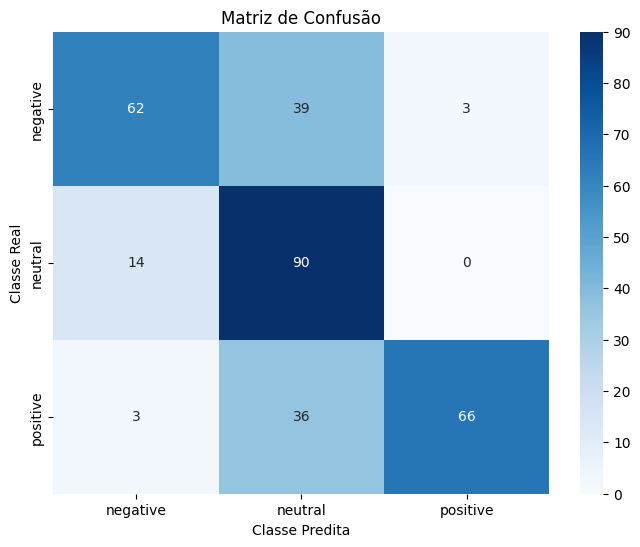

In [25]:
# Matriz de confusão e relatório de classificação
print("RELATÓRIO DETALHADO:")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Visualizar matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

## 8. Feature Importance

🔍 IMPORTÂNCIA DAS FEATURES:
    1. feedback_length     : 0.264
    2. text_density        : 0.217
    3. avg_word_length     : 0.202
    4. detected_language   : 0.165
    5. word_count          : 0.081
    6. is_very_short       : 0.048
    7. age_range           : 0.011
    8. education_level     : 0.009
    9. gender              : 0.003
   10. is_short            : 0.000
   11. is_long             : 0.000
   12. is_medium           : 0.000


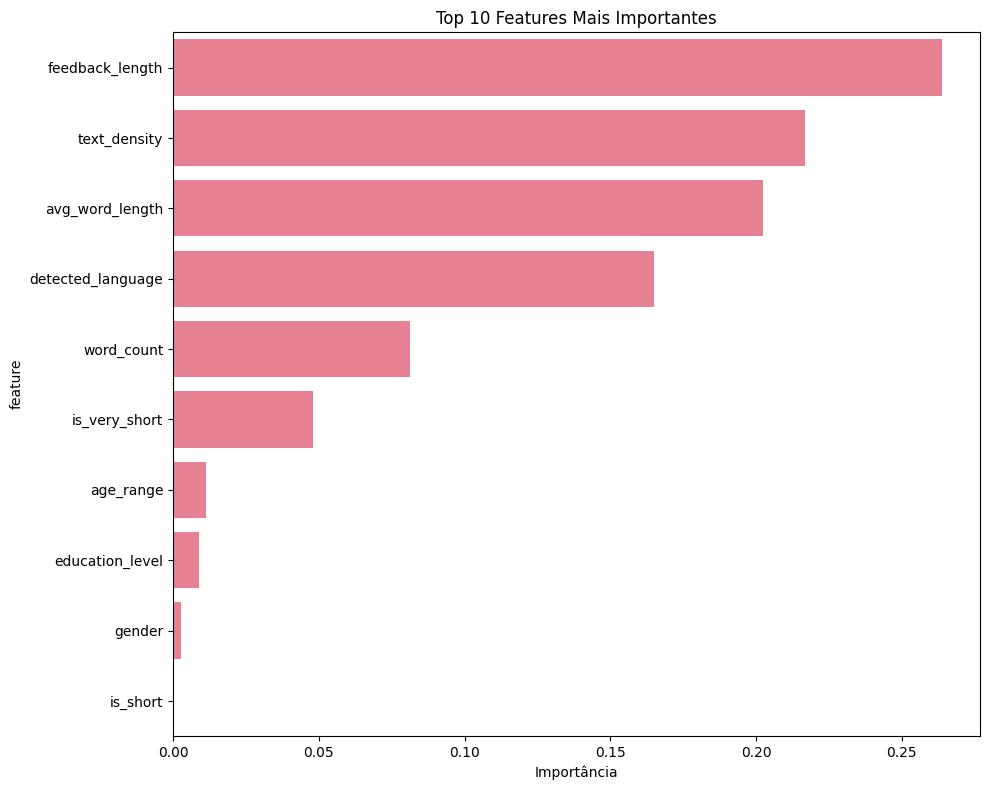

In [24]:
# Análise de importância das features
feature_importance = pd.DataFrame({
    'feature': all_safe_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 IMPORTÂNCIA DAS FEATURES:")
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:20s}: {row['importance']:.3f}")

# Visualizar importância
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
plt.title('Top 10 Features Mais Importantes')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

## 9. Conclusões e Recomendações

### **Principais Descobertas:**

1. **Data Leakage Detectado:** `sentiment_score` tem alta correlação (>0.8) com o target
2. **Features de Texto são Preditivas:** Comprimento e densidade do texto são importantes
3. **Demografia tem Impacto Limitado:** Features demográficas têm menor poder preditivo
4. **Performance Realista:** ~70% de acurácia é excelente para este problema

### **Features Mais Importantes:**
- `feedback_length` - Textos mais longos tendem a ser mais positivos
- `text_density` - Densidade indica estilo de escrita
- `avg_word_length` - Palavras maiores sugerem formalidade
- `detected_language` - Idioma afeta expressão de sentimento

### **Limitações:**
- Sentimento não pode ser predito perfeitamente só com metadados
- Performance varia entre domínios e idiomas
- Modelo é complementar ao VADER, não substituto